# Deep Ensembles with Randomized Prior Functions 

This notebook illustrates a way to improve predictive uncertainty using deep ensembles. It is based on this paper:

I. Osband, J. Aslanides, and A. Cassirer, “Randomized prior functions for deep reinforcement learning,” in NIPS, Jun. 2018 [Online]. Available: https://proceedings.neurips.cc/paper/2018/file/5a7b238ba0f6502e5d6be14424b20ded-Paper.pdf. 

The original  Tensorflow demo is from  https://www.kaggle.com/code/gdmarmerola/introduction-to-randomized-prior-functions/notebook

## Setup

In [1]:
!pip install -q dm-acme
!pip install -q dm-haiku==0.0.5
!pip install -q chex
!pip install -q optax
!pip install -q plotnine
!pip install -q git+https://github.com/deepmind/enn

In [2]:
import jax.numpy as jnp
import chex
import dataclasses
import pandas as pd
import numpy as np
import haiku as hk
import plotnine as gg
import matplotlib.pyplot as plt
from jax import random, vmap, nn
from typing import Dict, Sequence, Optional, Callable, List
from acme.utils.loggers.terminal import TerminalLogger

In [3]:
import enn.base as enn_base
from enn import utils
from enn import losses
from enn import networks
from enn import supervised
from enn import data_noise
from enn.networks import ensembles
from enn.networks import priors
import optax

## Dataset

We will use a 1d synthetic regression dataset from this paper

C. Blundell, J. Cornebise, K. Kavukcuoglu, and D. Wierstra, “Weight Uncertainty in Neural Networks,” in ICML, May 2015 [Online]. Available: http://arxiv.org/abs/1505.05424


$$
\begin{align}
y &= x + 0.3 \sin(2 \pi(x + \epsilon)) + 0.3 \sin(4 \pi(x + \epsilon)) + \epsilon \\
\epsilon &\sim \mathcal{N}(0, 0.02) \\
x &\sim \mathcal{U}(0.0, 0.5)
\end{align}
$$


In [4]:
def make_regression_data(key: chex.PRNGKey, n: int, minval: float, maxval: float):
    x_key, y_key = random.split(key)

    x = random.uniform(x_key, shape=(n, 1), minval=minval, maxval=maxval)

    # Define function
    def target_toy(key, x):
        epsilons = random.normal(key, shape=(3,)) * 0.02
        return (
            x
            + 0.3 * jnp.sin(2 * jnp.pi * (x + epsilons[0]))
            + 0.3 * jnp.sin(4 * jnp.pi * (x + epsilons[1]))
            + epsilons[2]
        )

    # Define vectorized version of function
    target_vmap = vmap(target_toy, in_axes=(0, 0), out_axes=0)

    # Generate target values
    keys = random.split(y_key, len(x))
    y = target_vmap(keys, x)
    return x, y

In [5]:
def make_dataset(
    key: chex.PRNGKey = random.PRNGKey(0), n: int = 100, minval: float = -1.0, maxval: float = 1.0
) -> enn_base.BatchIterator:
    """Factory method to produce an iterator of Batches."""
    x, y = make_regression_data(key, n, minval, maxval)
    data = enn_base.Batch(
        x=x,
        y=y,
    )
    chex.assert_shape(data.x, (None, 1))
    chex.assert_shape(data.y, (None, 1))
    return utils.make_batch_iterator(data)

In [6]:
n = 100
minval, maxval = 0.0, 0.5
key = random.PRNGKey(0)
dataset = make_dataset(key, n, minval, maxval)

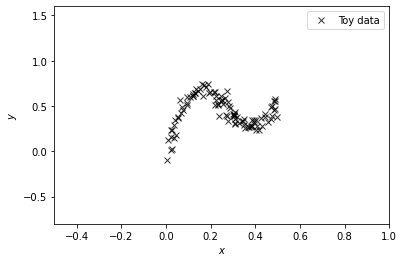

In [7]:
x, y = make_regression_data(key, n, minval, maxval)

# Plot the generated data
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(x, y, "kx", label="Toy data", alpha=0.8)

# plt.title('Simple 1D example with toy data by Blundell et. al (2015)')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.8, 1.6)
plt.legend()
plt.show()

## Model

### Configuration

In [8]:
@dataclasses.dataclass
class Config:
    num_batch: int = 2_000
    index_dim: int = 1
    num_index_samples: int = 10
    seed: int = 0
    prior_scale: float = 3.0
    learning_rate: float = 0.03
    noise_std: float = 0.1


FLAGS = Config()

We add a new argument, namely activation, to the original [MLPEnsembleMatchedPrior](https://github.com/deepmind/enn/blob/55cac99fe10fb6a4f193fccf3287d884bc2ba446/enn/networks/ensembles.py#L156) in enn repository.

### Definition

In [9]:
class MLPEnsembleMatchedPrior(enn_base.EpistemicNetwork):
    """Ensemble of MLPs with matched prior functions."""

    def __init__(
        self,
        output_sizes: Sequence[int],
        dummy_input: enn_base.Array,
        num_ensemble: int,
        prior_scale: float = 1.0,
        seed: int = 0,
        w_init: Optional[hk.initializers.Initializer] = None,
        b_init: Optional[hk.initializers.Initializer] = None,
        activation: Callable[[jnp.ndarray], jnp.ndarray] = nn.relu,
    ):
        """Ensemble of MLPs with matched prior functions."""
        mlp_priors = ensembles.make_mlp_ensemble_prior_fns(output_sizes, dummy_input, num_ensemble, seed)

        def net_fn(x: enn_base.Array) -> enn_base.Array:
            x = hk.Flatten()(x)
            return hk.nets.MLP(output_sizes, w_init, b_init, activation=activation)(x)

        transformed = hk.without_apply_rng(hk.transform(net_fn))

        ensemble = ensembles.Ensemble(transformed, num_ensemble)
        enn = priors.EnnWithAdditivePrior(
            enn=ensemble,
            prior_fn=ensembles.combine_functions_choice_via_index(mlp_priors),
            prior_scale=prior_scale,
        )
        super().__init__(enn.apply, enn.init, enn.indexer)

### Initialization

In [10]:
dummy_input = jnp.ones((n, 1))
output_sizes = [16, 16, 1]

# Create Ensemble ENN with a prior network
enn = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
    # use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
    activation=nn.elu,
)

## Experiment

In [11]:
# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

In [12]:
# L2 loss on perturbed outputs
single_loss = losses.L2Loss()
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [13]:
# Logger
logger = TerminalLogger("supervised_regression")

# Aggregating different components of the experiment
experiment = supervised.Experiment(enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [14]:
# Train the experiment
experiment.train(FLAGS.num_batch)

In [15]:
def make_regression_df(
    key: chex.PRNGKey = random.PRNGKey(0), n: int = 100, minval: float = -1.0, maxval: float = 1.0
) -> pd.DataFrame:
    """Generate a panda dataframe with sampled predictions."""

    x, y = make_regression_data(key, n, minval, maxval)
    return pd.DataFrame({"x": x[:, 0], "y": y[:, 0]}).reset_index()

In [16]:
def make_plot_data(experiment: supervised.BaseExperiment, num_sample: int = 20) -> pd.DataFrame:
    """Generate a panda dataframe with sampled predictions."""
    preds_x = np.linspace(-0.5, 1.0).reshape((-1, 1))

    data = []
    rng = hk.PRNGSequence(random.PRNGKey(seed=0))
    for k in range(num_sample):
        net_out = experiment.predict(preds_x, key=next(rng))
        preds_y = utils.parse_net_output(net_out)

        data.append(pd.DataFrame({"x": preds_x[:, 0], "y": preds_y[:, 0], "k": k}))
    plot_df = pd.concat(data)
    return plot_df

In [17]:
def make_plot(experiment: supervised.BaseExperiment, num_sample: int = 20, dataset_kwargs: Dict = {}) -> gg.ggplot:
    """Generate a regression plot with sampled predictions."""

    plot_df = make_plot_data(experiment, num_sample=num_sample)

    p = (
        gg.ggplot()
        + gg.aes("x", "y")
        + gg.geom_point(data=make_regression_df(**dataset_kwargs), size=3, colour="blue")
        + gg.geom_line(gg.aes(group="k"), data=plot_df, alpha=0.5)
    )

    return p

## Plot the output

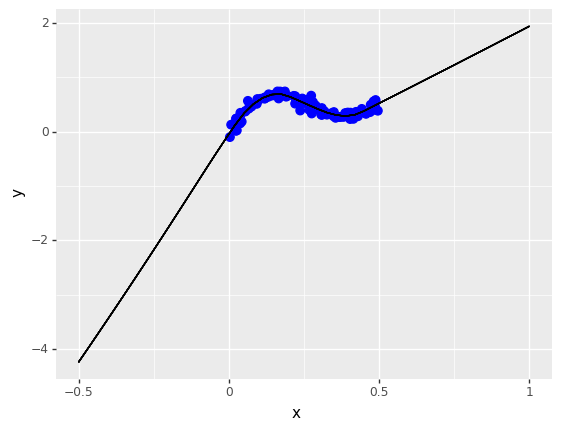

In [18]:
dataset_kwargs = {"n": n, "minval": minval, "maxval": maxval, "key": random.PRNGKey(0)}

p = make_plot(experiment, dataset_kwargs=dataset_kwargs)
_ = p.draw()

In [19]:
x_grid = jnp.linspace(-5, 5, 1000).reshape(-1, 1)

indexer = experiment.enn.indexer
params = experiment.state.params

index_key, key = random.split(key)
output_with_prior = experiment.enn.apply(params, x_grid, indexer(index_key))
y_model = output_with_prior.prior + output_with_prior.train

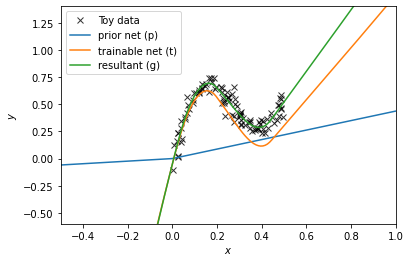

In [20]:
# Plot the results
plt.figure()  # figsize=[12,6], dpi=200)
plt.plot(x, y, "kx", label="Toy data", alpha=0.8)
plt.plot(x_grid, output_with_prior.prior, label="prior net (p)")
plt.plot(x_grid, output_with_prior.train, label="trainable net (t)")
plt.plot(x_grid, y_model, label="resultant (g)")
# plt.title('Predictions of the prior network: random function')
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.5, 1.0)
plt.ylim(-0.6, 1.4)
plt.legend()

plt.savefig("randomized_priors_single_model.pdf")
plt.savefig("randomized_priors_single_model.png")

plt.show()

## Bootstrapped Ensembles

To implement bootstrapping using JAX, we generate a random map from seed values to dataset index values: $\{\text{seed}, \text{seed}+1 \dots, \text{seed}+99\} \to \{ 0, 1, \dots, 99 \}$ by utilizing ``` jax.random.randint ```  using a randomly-generated seed. We assume the random key space is large enough that we need not be concerned with generating overlapping seed ranges.

### Configuration

In [21]:
@dataclasses.dataclass
class Config:
    num_batch: int = 3_000
    index_dim: int = 8
    num_index_samples: int = 8
    seed: int = 0
    prior_scale: float = 3.0
    learning_rate: float = 0.03
    noise_std: float = 0.0
    distribution: str = "uniform"


FLAGS = Config()

### Dataset Initialization

In [22]:
n = 100
minval, maxval = 0.0, 0.5
key = random.PRNGKey(0)
dataset = make_dataset(key, n, minval, maxval)

### Model Initialization

In [23]:
dummy_input = jnp.ones((n, 1))
output_sizes = [16, 16, 1]

# Create Ensemble ENN with a prior network
enn = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
    # use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
    activation=nn.elu,
)

In [24]:
# Add bootstrapping
boot_fn = data_noise.BootstrapNoise(enn, FLAGS.distribution)
single_loss = losses.add_data_noise(losses.L2Loss(), boot_fn)
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [25]:
# Aggregating different components of the experiment
experiment = supervised.Experiment(enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [26]:
experiment.train(FLAGS.num_batch)

### Plot the output

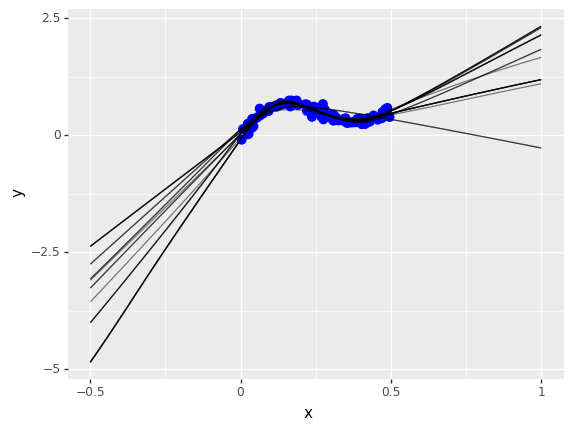

In [27]:
dataset_kwargs = {"n": n, "minval": minval, "maxval": maxval, "key": random.PRNGKey(0)}

p = make_plot(experiment, dataset_kwargs=dataset_kwargs)
_ = p.draw()

In [28]:
def get_predictions(params, index):
    output_with_prior = experiment.enn.apply(params, x_grid, index)
    return output_with_prior.prior, output_with_prior.train


params = experiment.state.params
indices = jnp.arange(FLAGS.index_dim)
y_priors, y_trains = vmap(get_predictions, in_axes=(None, 0))(params, indices)

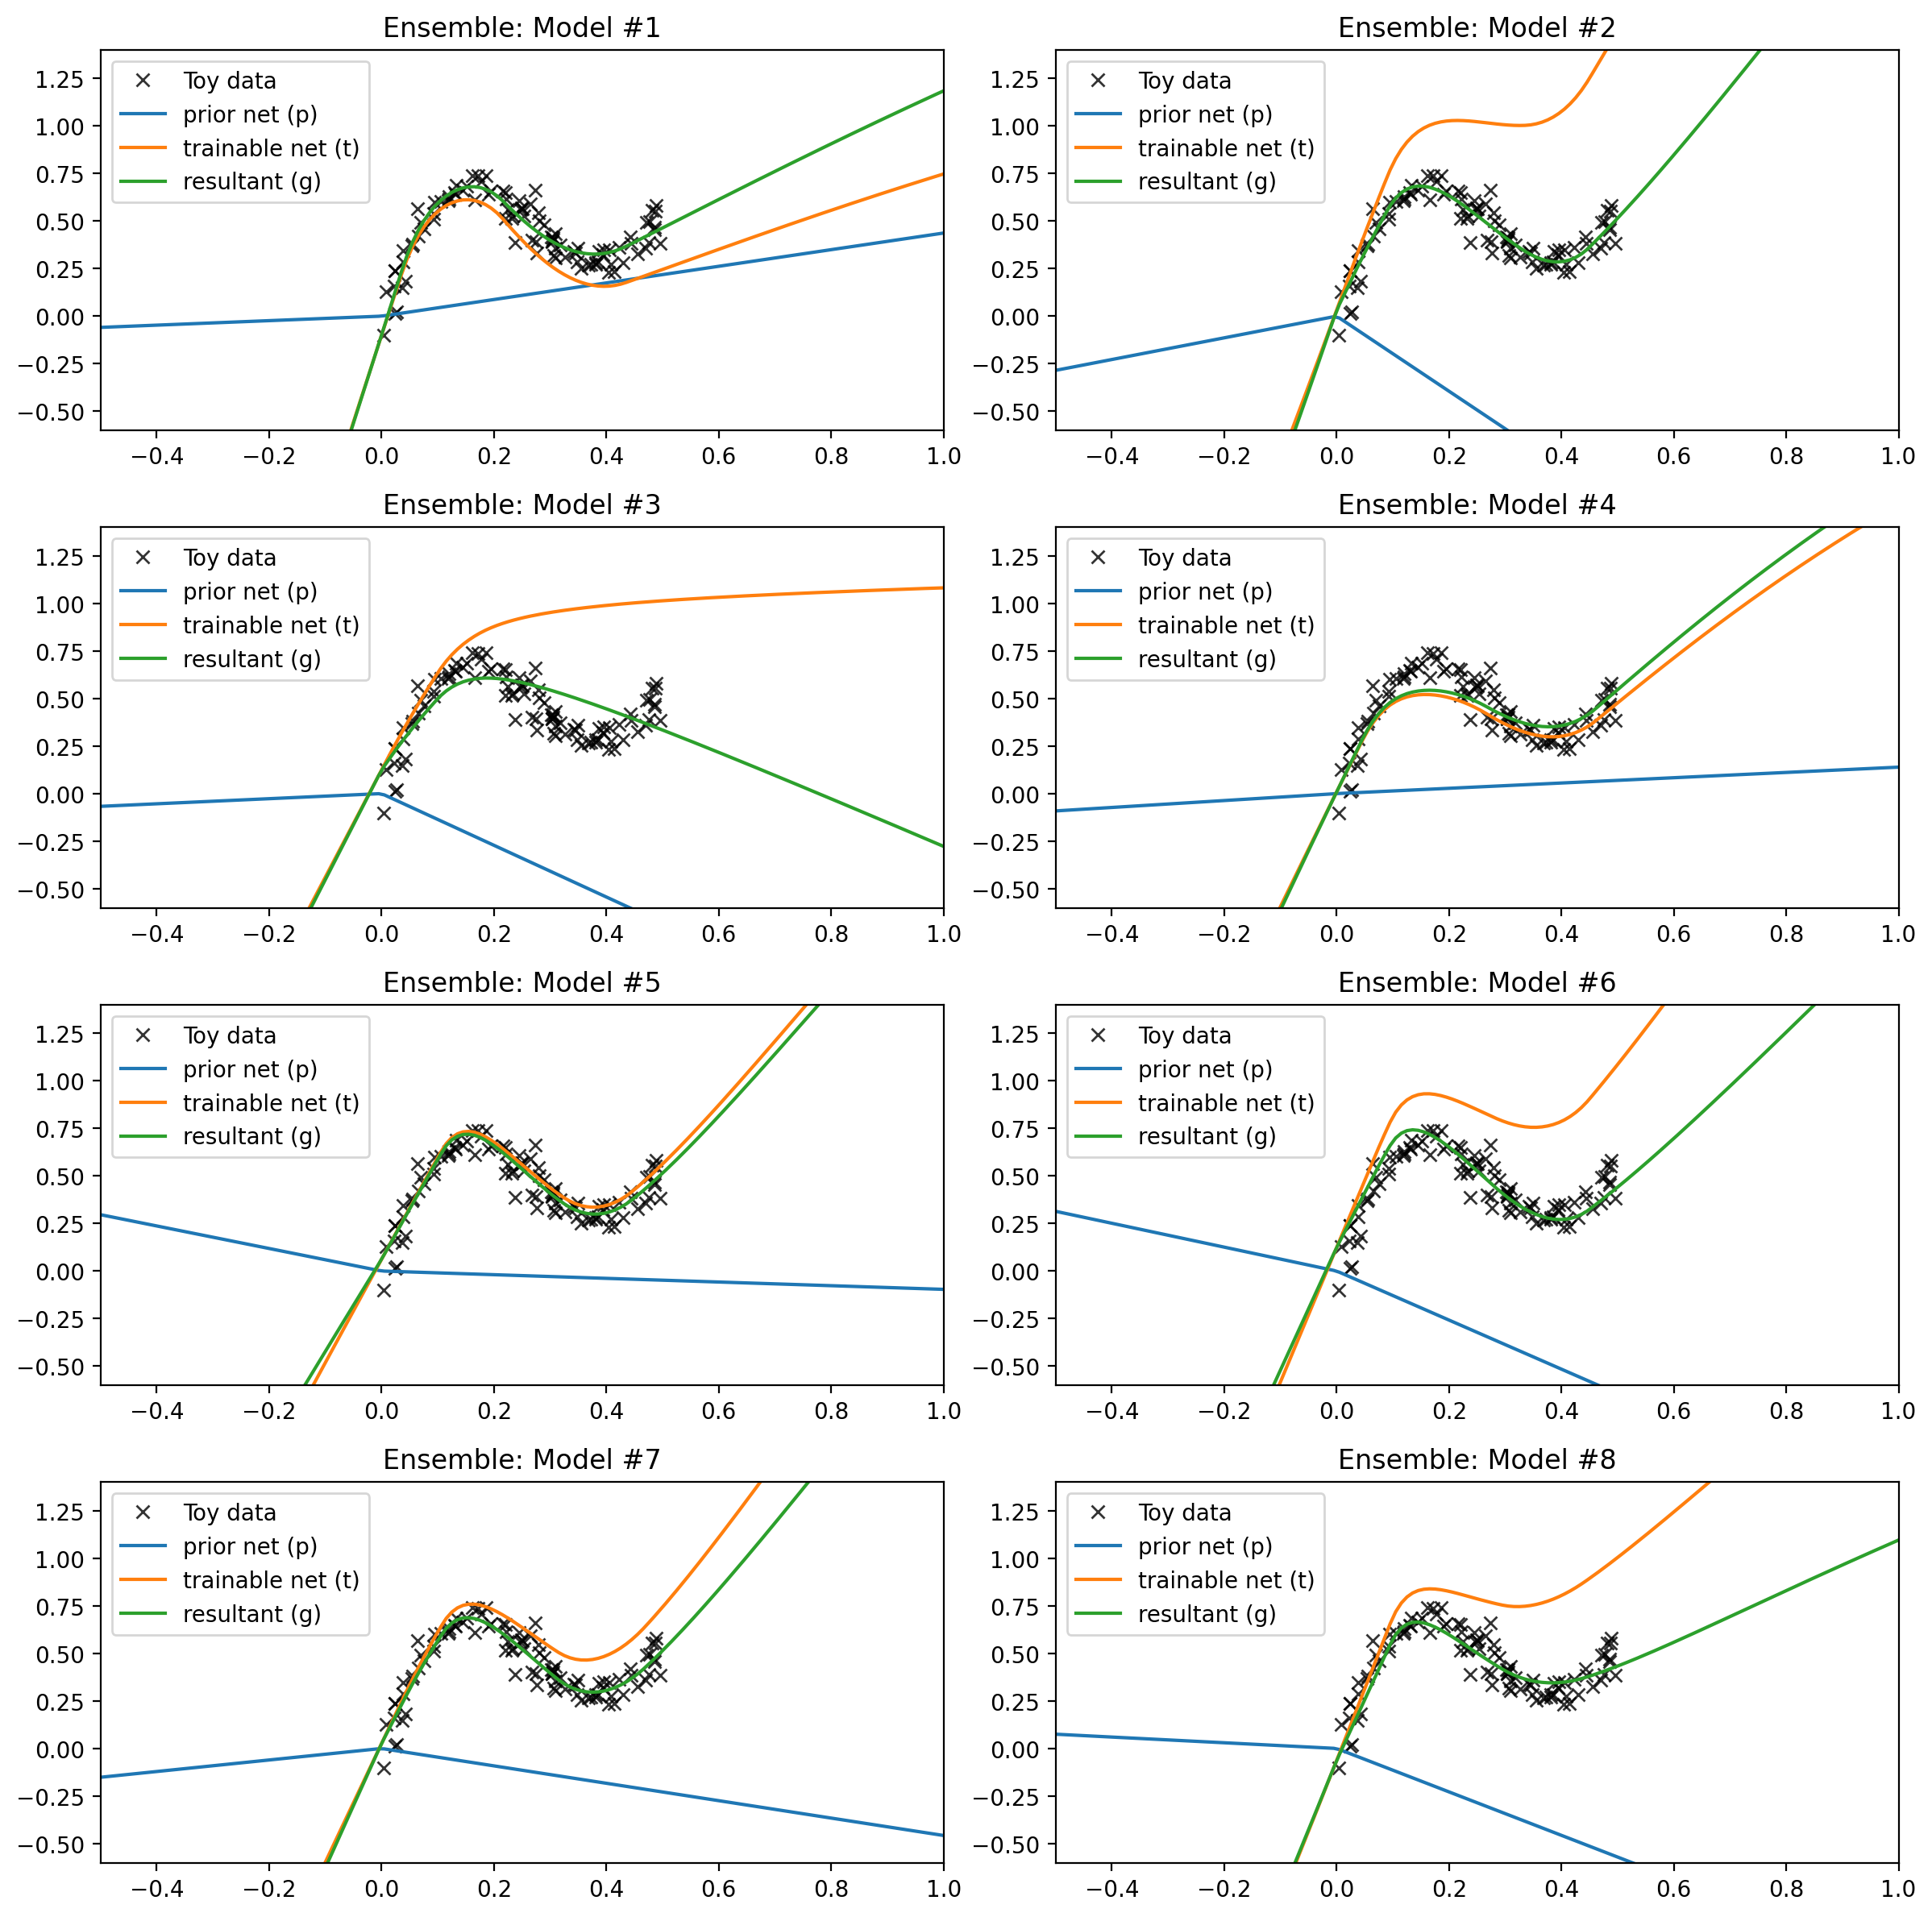

In [29]:
# Plot the results
plt.figure(figsize=(12, 12), dpi=200)

for i, (y_prior, y_train) in enumerate(zip(y_priors, y_trains)):
    plt.subplot(4, 2, i + 1)
    plt.plot(x, y, "kx", label="Toy data", alpha=0.8)
    plt.plot(x_grid, y_prior, label="prior net (p)")
    plt.plot(x_grid, y_train, label="trainable net (t)")
    plt.plot(x_grid, y_prior + y_train, label="resultant (g)")
    plt.title("Ensemble: Model #{}".format(i + 1))
    plt.xlim(-0.5, 1.0)
    plt.ylim(-0.6, 1.4)
    plt.legend()

plt.tight_layout()

plt.savefig("randomized_priors_multi_model.pdf")
plt.savefig("randomized_priors_multi_model.png")
plt.show();

# 4. Effects of Changing Beta

Let us go beyond the original Kaggle notebook and inspect that relationship between the weight of the prior, $\beta$ and the variance among the predictions of the ensembled models.

Intuitively, since the random priors are not trained, the variance should increase with $\beta$. Let us verify this visually.

In [30]:
def sweep(prior_scale):
    # Create Ensemble ENN with a prior network
    enn = MLPEnsembleMatchedPrior(
        output_sizes=output_sizes,
        dummy_input=dummy_input,
        num_ensemble=FLAGS.index_dim,
        prior_scale=prior_scale,
        seed=FLAGS.seed,
        # use glorot normal as a kernel initializer
        w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
        activation=nn.elu,
    )

    # Add bootstrapping
    boot_fn = data_noise.BootstrapNoise(enn, FLAGS.distribution)
    single_loss = losses.add_data_noise(losses.L2Loss(), boot_fn)
    loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

    # Aggregating different components of the experiment
    experiment = supervised.Experiment(enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

    experiment.train(FLAGS.num_batch)
    params = experiment.state.params
    indices = jnp.arange(FLAGS.index_dim)
    y_prior, y_train = vmap(get_predictions, in_axes=(None, 0))(params, indices)
    return y_prior, y_train

In [31]:
# Choose a diverse selection of beta values
prior_scales = jnp.array([0.001, 5.0, 50.0, 100.0])
y_priors, y_trains = vmap(sweep)(prior_scales)

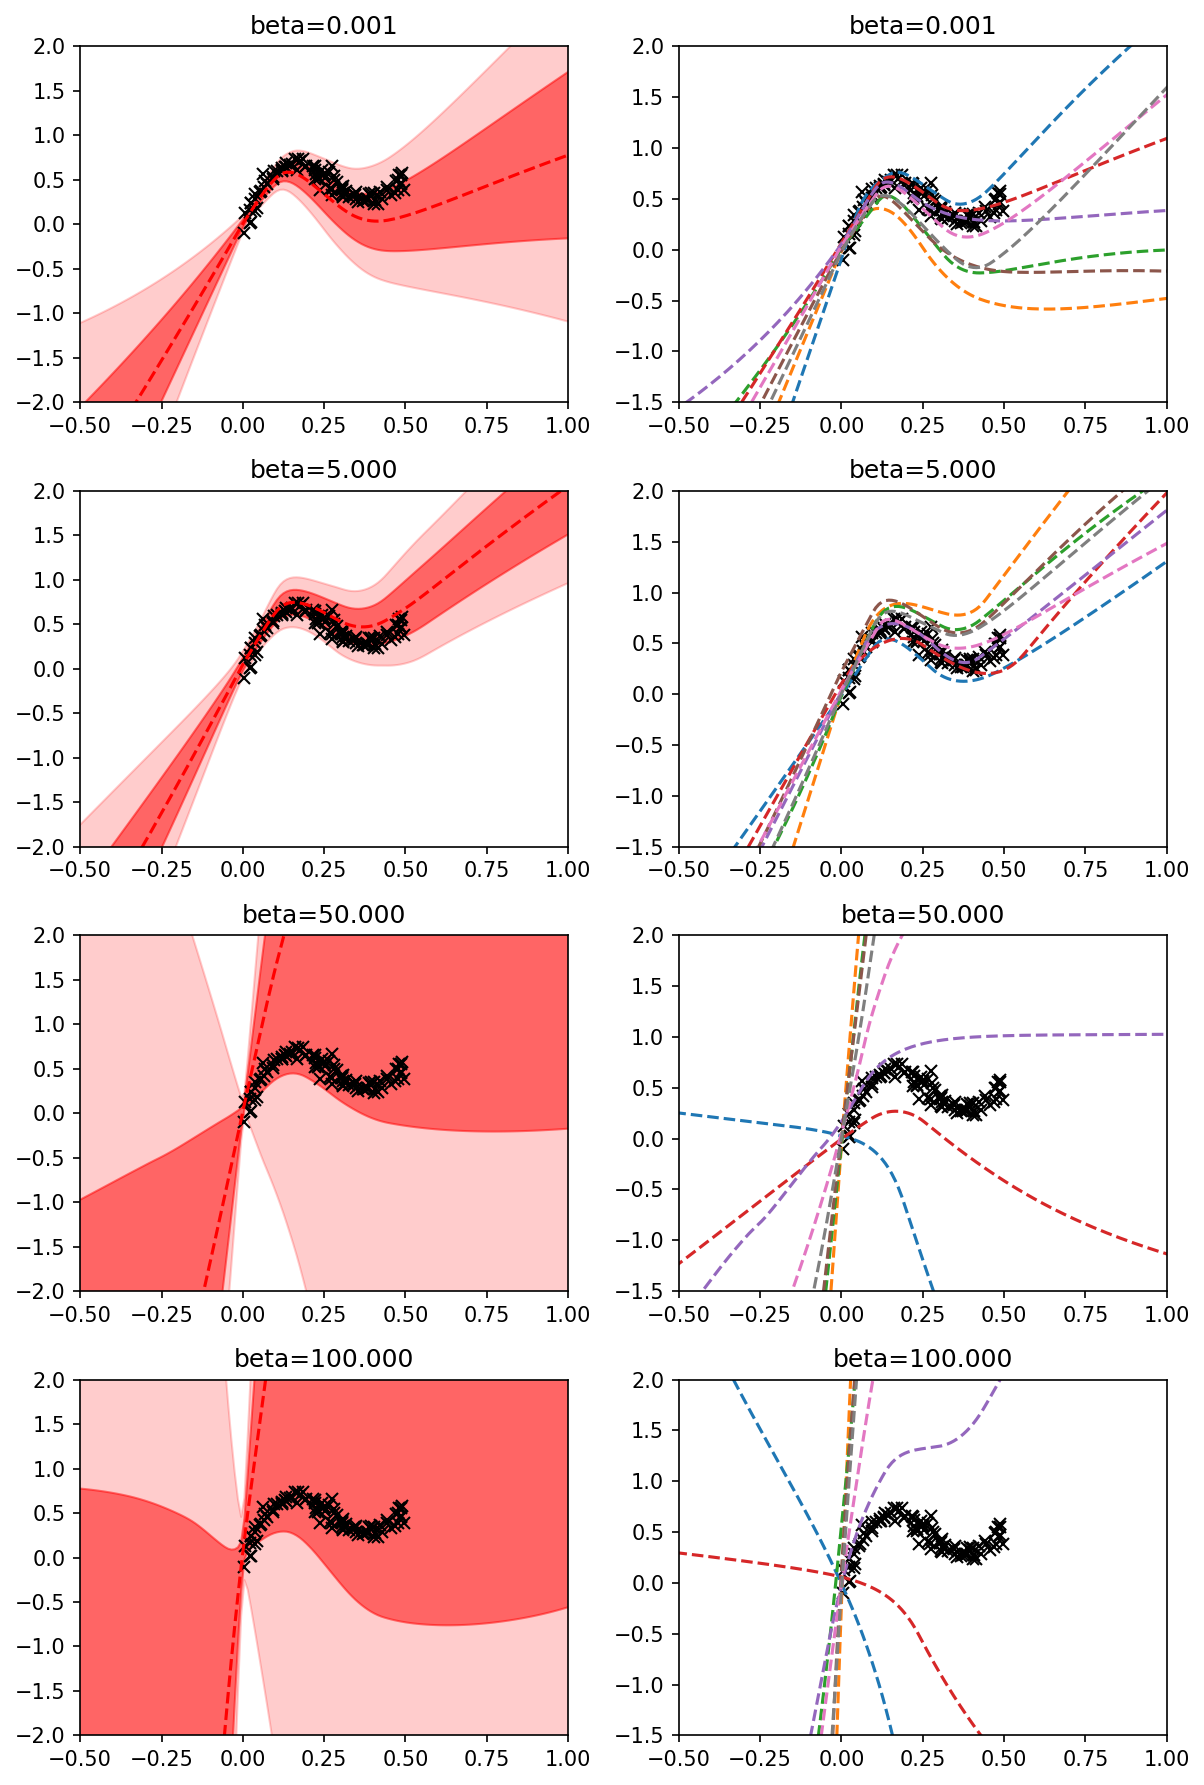

In [32]:
# Plot mean and std for each beta
fig = plt.figure(figsize=[8, len(prior_scales) * 3], dpi=150)

for i, (beta, y_prior, y_train) in enumerate(zip(prior_scales, y_priors, y_trains)):
    y_pred = y_prior + y_train
    y_mean = jnp.mean(y_pred, axis=0)
    y_std = jnp.std(y_pred, axis=0)

    # Plot predictive mean and std (left graph)
    plt.subplot(len(prior_scales), 2, 2 * i + 1)
    plt.plot(x, y, "kx", label="Toy data")
    # plt.title(f'Mean and Deviation for beta={beta}', fontsize=12)
    plt.title(f"beta={beta:.3f}")
    plt.xlim(-0.5, 1.0)
    plt.ylim(-2, 2)
    # plt.legend()
    plt.plot(x_grid, y_mean, "r--", linewidth=1.5)

    plt.fill_between(
        x_grid.reshape(1, -1)[0], jnp.squeeze(y_mean - y_std), jnp.squeeze(y_mean + y_std), alpha=0.5, color="red"
    )

    plt.fill_between(
        x_grid.reshape(1, -1)[0],
        jnp.squeeze(y_mean + 2 * y_std),
        jnp.squeeze(y_mean - 2 * y_std),
        alpha=0.2,
        color="red",
    )

    # Plot means of each net in ensemble (right graph)
    plt.subplot(len(prior_scales), 2, 2 * i + 2)
    plt.plot(x, y, "kx", label="Toy data")
    plt.title(f"beta={beta:.3f}")
    plt.xlim(-0.5, 1.0)
    plt.ylim(-1.5, 2)

    for pred in y_pred:
        plt.plot(x_grid, pred, linestyle="--", linewidth=1.5)

plt.tight_layout()
plt.savefig("randomized_priors_changing_beta.pdf")
plt.savefig("randomized_priors_changing_beta.png")
plt.show()

# 5. Effects of Prior and Bootstrapping

Let us construct and compare the following four models:


1. Ensemble of nets **with** prior, **with** bootstrap (original model)
2. Ensemble of nets **with** prior, **without** bootstrap
3. Ensemble of nets **without** prior, **with** bootstrap
4. Ensemble of nets **without** prior, **without** bootstrap

Note that our previous constructions allow easy extensions into the three other model types. For nets without prior, we simply set ```beta=0```

In [33]:
dummy_input = jnp.ones((n, 1))
prior_scale = 3.0

# Create Ensemble ENN with a prior network
enn_wo_prior = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=0.0,
    seed=FLAGS.seed,
    # use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
    activation=nn.elu,
)
enn = MLPEnsembleMatchedPrior(
    output_sizes=output_sizes,
    dummy_input=dummy_input,
    num_ensemble=FLAGS.index_dim,
    prior_scale=prior_scale,
    seed=FLAGS.seed,
    # use glorot normal as a kernel initializer
    w_init=hk.initializers.VarianceScaling(1.0, "fan_avg", "truncated_normal"),
    activation=nn.elu,
)

boot_fn = data_noise.BootstrapNoise(enn, FLAGS.distribution)
single_loss = losses.add_data_noise(single_loss, boot_fn)
loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [34]:
# L2 loss on perturbed outputs
loss_fn = losses.average_single_index_loss(losses.L2Loss(), FLAGS.num_index_samples)

boot_fn = data_noise.BootstrapNoise(enn, FLAGS.distribution)
single_loss = losses.add_data_noise(losses.L2Loss(), boot_fn)
bootstrap_loss_fn = losses.average_single_index_loss(single_loss, FLAGS.num_index_samples)

In [35]:
# Aggregating different components of the experiment
experiment1 = supervised.Experiment(enn, bootstrap_loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)


experiment2 = supervised.Experiment(enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

experiment3 = supervised.Experiment(enn_wo_prior, bootstrap_loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

experiment4 = supervised.Experiment(enn_wo_prior, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [36]:
# Train the experiment
experiment1.train(FLAGS.num_batch)
experiment2.train(FLAGS.num_batch)
experiment3.train(FLAGS.num_batch)
experiment4.train(FLAGS.num_batch)

In [37]:
params1 = experiment1.state.params
y_prior, y_train = vmap(get_predictions, in_axes=(None, 0))(params1, indices)
y1 = y_prior + y_train

params2 = experiment2.state.params
y_prior, y_train = vmap(get_predictions, in_axes=(None, 0))(params2, indices)
y2 = y_prior + y_train

params3 = experiment3.state.params
y_prior, y_train = vmap(get_predictions, in_axes=(None, 0))(params3, indices)
y3 = y_prior + y_train

params4 = experiment4.state.params
y_prior, y_train = vmap(get_predictions, in_axes=(None, 0))(params4, indices)
y4 = y_prior + y_train

In [38]:
means_1 = jnp.squeeze(jnp.mean(y1, axis=0))
stds_1 = jnp.squeeze(jnp.std(y1, axis=0))

means_2 = jnp.squeeze(jnp.mean(y2, axis=0))
stds_2 = jnp.squeeze(jnp.std(y2, axis=0))

means_3 = jnp.squeeze(jnp.mean(y3, axis=0))
stds_3 = jnp.squeeze(jnp.std(y3, axis=0))

means_4 = jnp.squeeze(jnp.mean(y4, axis=0))
stds_4 = jnp.squeeze(jnp.std(y4, axis=0))

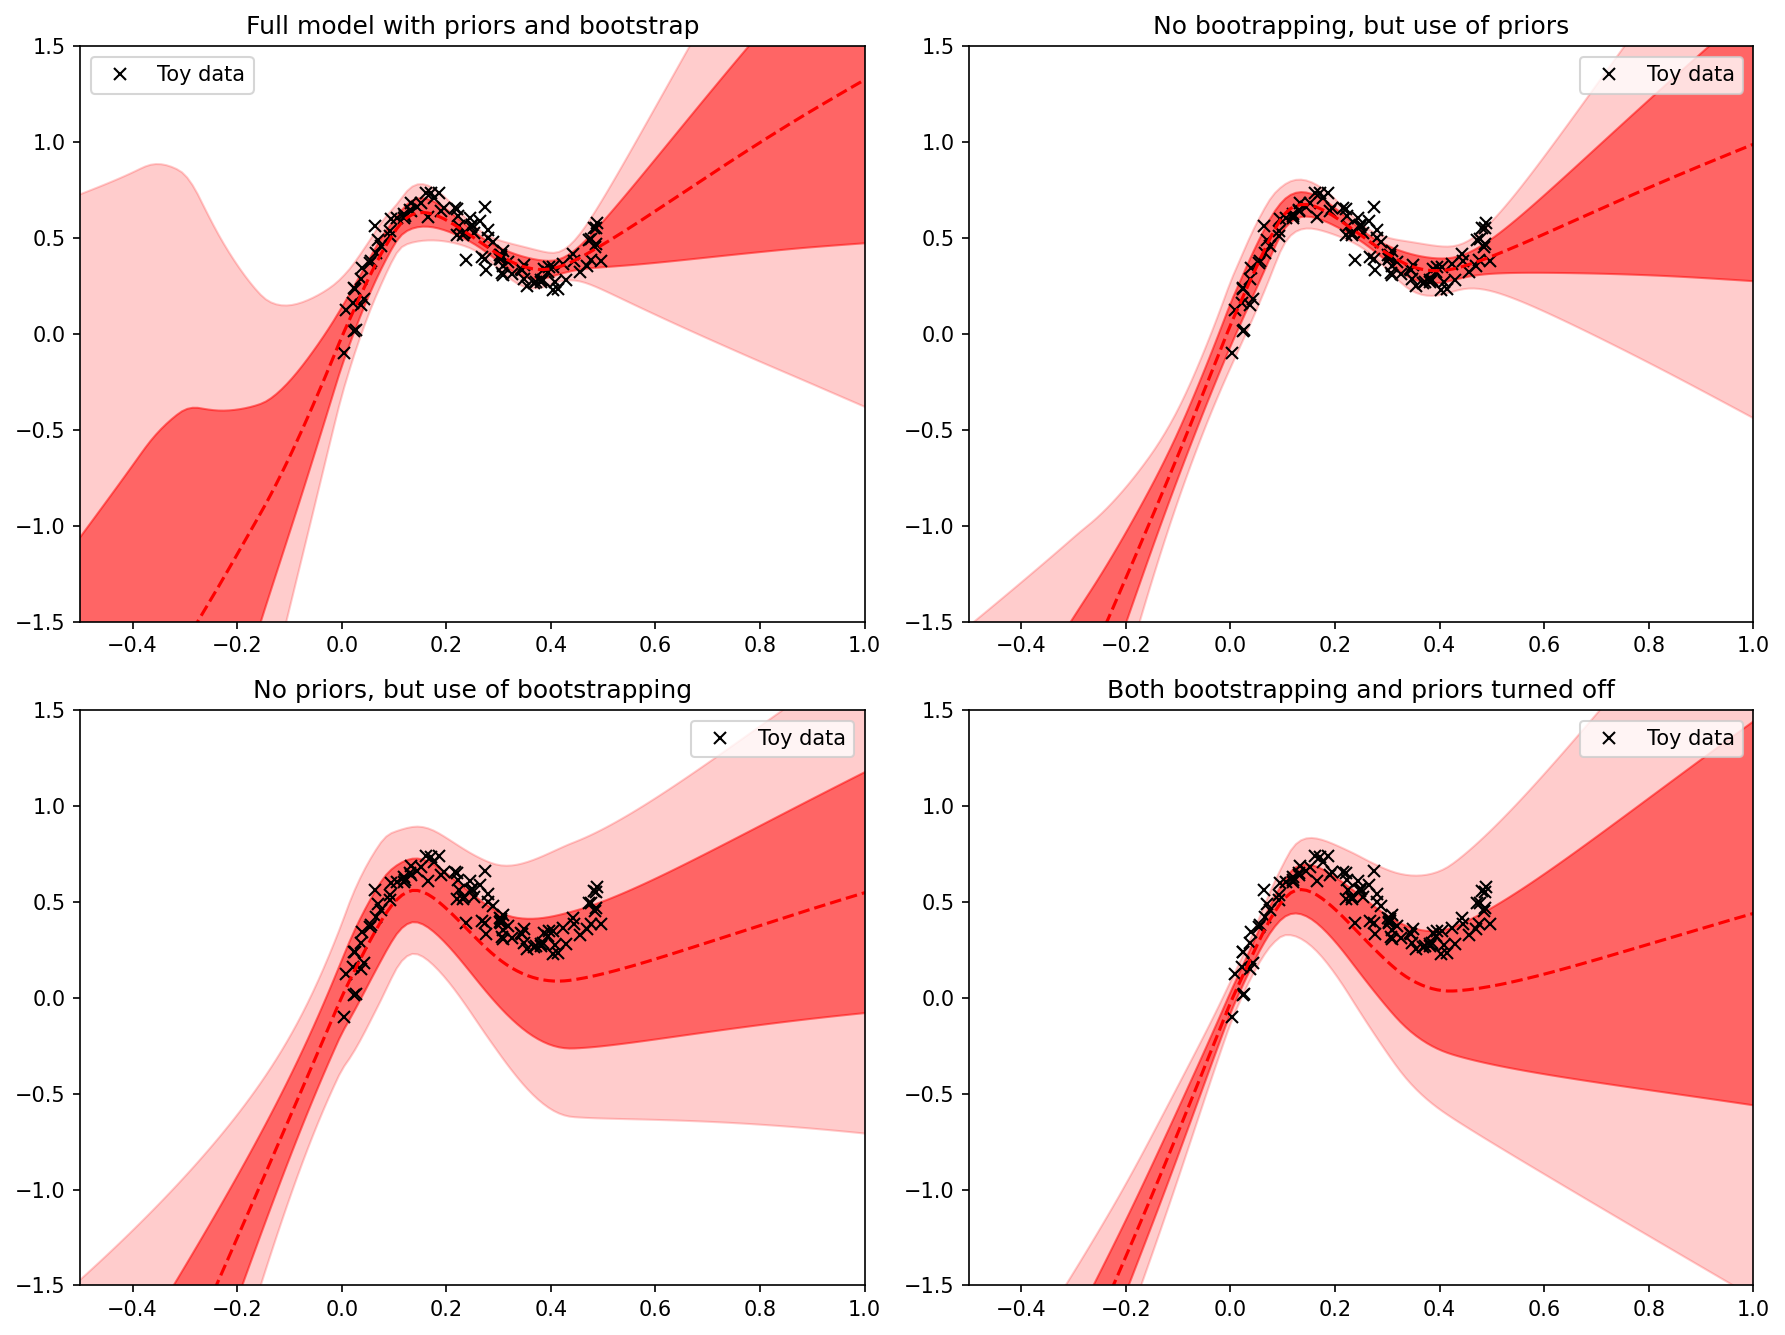

In [39]:
# Plot the four types of models
fig = plt.figure(figsize=[12, 9], dpi=150)
# fig.suptitle('Bootstrapping and priors: impact of model components on result',
#             verticalalignment='center')

# With prior, with bootstrap
plt.subplot(2, 2, 1)
plt.plot(x, y, "kx", label="Toy data")
plt.title("Full model with priors and bootstrap", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_1, "r--", linewidth=1.5)

plt.fill_between(x_grid.reshape(1, -1)[0], means_1 - stds_1, means_1 + stds_1, alpha=0.5, color="red")

plt.fill_between(x_grid.reshape(1, -1)[0], means_1 + 2 * stds_1, means_1 - 2 * stds_1, alpha=0.2, color="red")

# With prior, without bootstrap
plt.subplot(2, 2, 2)
plt.plot(x, y, "kx", label="Toy data")
plt.title("No bootrapping, but use of priors", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_2, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_2 - stds_2, means_2 + stds_2, alpha=0.5, color="red")

plt.fill_between(x_grid.reshape(1, -1)[0], means_2 + 2 * stds_2, means_2 - 2 * stds_2, alpha=0.2, color="red")

# Without prior, with bootstrap
plt.subplot(2, 2, 3)
plt.plot(x, y, "kx", label="Toy data")
plt.title("No priors, but use of bootstrapping", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_3, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_3 - stds_3, means_3 + stds_3, alpha=0.5, color="red")

plt.fill_between(x_grid.reshape(1, -1)[0], means_3 + 2 * stds_3, means_3 - 2 * stds_3, alpha=0.2, color="red")

# Without prior, without bootstrap
plt.subplot(2, 2, 4)
plt.plot(x, y, "kx", label="Toy data")
plt.title("Both bootstrapping and priors turned off", fontsize=12)
plt.xlim(-0.5, 1.0)
plt.ylim(-1.5, 1.5)
plt.legend()
plt.plot(x_grid, means_4, "r--", linewidth=1.5)
plt.fill_between(x_grid.reshape(1, -1)[0], means_4 - stds_4, means_4 + stds_4, alpha=0.5, color="red")

plt.fill_between(x_grid.reshape(1, -1)[0], means_4 + 2 * stds_4, means_4 - 2 * stds_4, alpha=0.2, color="red")

plt.tight_layout()
plt.savefig("randomized_priors_components.pdf")
plt.savefig("randomized_priors_components.png")
plt.show();